Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - loss: 231594885120.0000 - mae: 437727.9062 - val_loss: 212587560960.0000 - val_mae: 416719.4062
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 230894649344.0000 - mae: 438623.0000 - val_loss: 197150326784.0000 - val_mae: 397769.0000
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 197154996224.0000 - mae: 398082.7500 - val_loss: 41124605952.0000 - val_mae: 170725.4062
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 48253935616.0000 - mae: 187584.9531 - val_loss: 39429091328.0000 - val_mae: 168817.4844
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 41742127104.0000 - mae: 174992.7188 - val_loss: 39084118016.0000 - val_mae: 170909.4688
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 42368167936.0000 - mae: 177698.8594 - val_loss: 39527096320.0000 - val_mae: 171998.0469
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 39550074880.0000 - mae: 168945.7812 - val_loss

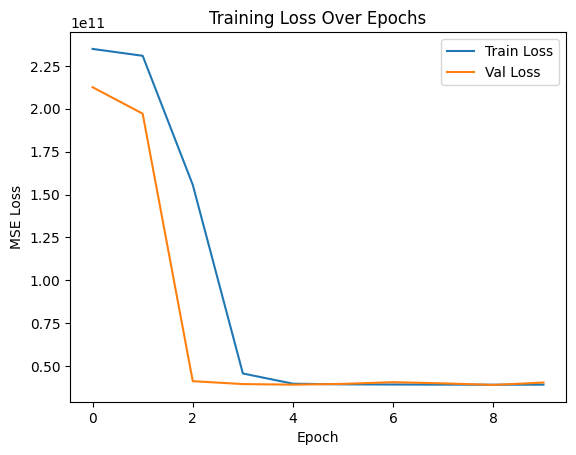

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Simulate Tabular Data
num_samples = 1000
tabular_data = pd.DataFrame({
    'sqft': np.random.randint(500, 5000, num_samples),
    'bedrooms': np.random.randint(1, 6, num_samples),
    'bathrooms': np.random.randint(1, 4, num_samples),
    'year_built': np.random.randint(1950, 2022, num_samples)
})
tabular_data['price'] = (
    tabular_data['sqft'] * 150 +
    tabular_data['bedrooms'] * 10000 +
    tabular_data['bathrooms'] * 5000 +
    (2022 - tabular_data['year_built']) * -500 +
    np.random.normal(0, 25000, num_samples)  # Add noise
)

# Simulate Image Data (house images as random noise for now)
image_height, image_width = 64, 64
image_data = np.random.rand(num_samples, image_height, image_width, 3)

# Preprocess Tabular Data
X_tabular = tabular_data.drop(columns=['price']).values
y = tabular_data['price'].values

scaler = StandardScaler()
X_tabular_scaled = scaler.fit_transform(X_tabular)

# Train-test split
X_tab_train, X_tab_test, X_img_train, X_img_test, y_train, y_test = train_test_split(
    X_tabular_scaled, image_data, y, test_size=0.2, random_state=42
)

# Build CNN for Image Feature Extraction
image_input = Input(shape=(image_height, image_width, 3))
x = layers.Conv2D(32, (3,3), activation='relu')(image_input)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
image_features = layers.Dense(32, activation='relu')(x)

# Tabular Input Model
tabular_input = Input(shape=(X_tabular.shape[1],))
y = layers.Dense(32, activation='relu')(tabular_input)
y = layers.Dense(16, activation='relu')(y)

# Combine Both Modalities
combined = layers.concatenate([image_features, y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)
output = layers.Dense(1)(z)

# Build and Compile Model
model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train Model
history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate Model
y_pred = model.predict([X_img_test, X_tab_test]).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()
